In [3]:
!tar -xvzf dataset.tar.gz

circles_bot_gan/
circles_bot_gan/GAN35_287.txt
circles_bot_gan/GAN25_58.txt
circles_bot_gan/GAN18_56.txt
circles_bot_gan/GAN29_167.txt
circles_bot_gan/GAN18_23.txt
circles_bot_gan/GAN35_338.txt
circles_bot_gan/GAN34_139.txt
circles_bot_gan/GAN18_81.txt
circles_bot_gan/GAN29_415.txt
circles_bot_gan/GAN35_324.txt
circles_bot_gan/GAN29_17.txt
circles_bot_gan/GAN29_192.txt
circles_bot_gan/GAN35_308.txt
circles_bot_gan/GAN29_146.txt
circles_bot_gan/GAN34_103.txt
circles_bot_gan/GAN29_107.txt
circles_bot_gan/GAN35_444.txt
circles_bot_gan/GAN29_156.txt
circles_bot_gan/GAN29_100.txt
circles_bot_gan/GAN29_113.txt
circles_bot_gan/GAN35_301.txt
circles_bot_gan/GAN34_320.txt
circles_bot_gan/GAN34_107.txt
circles_bot_gan/GAN27_55.txt
circles_bot_gan/GAN29_250.txt
circles_bot_gan/GAN27_25.txt
circles_bot_gan/GAN32_112.txt
circles_bot_gan/GAN27_20.txt
circles_bot_gan/GAN29_10.txt
circles_bot_gan/GAN32_43.txt
circles_bot_gan/GAN29_335.txt
circles_bot_gan/GAN29_284.txt
circles_bot_gan/GAN27_92.txt
circ

In [4]:
import json
from typing import List
import numpy as np
import tensorflow as tf

data = json.load(open('sessions.json'))

h_sesh: List[str] = data['human']
h_sesh = [sesh.removeprefix('../../python/') for sesh in h_sesh]
human_sessions = tf.constant(h_sesh)

b_sesh: List[str] = data['bot']
b_sesh = [sesh.removeprefix('../../python/') for sesh in b_sesh]
bot_sessions = tf.constant(b_sesh)

print(human_sessions, bot_sessions)

tf.Tensor(
[b'circles_human_pc1/circleHide_1664743415080.txt'
 b'circles_human_pc1/circleHide_1664743075448.txt'
 b'circles_human_pc1/circleHide_1664743217057.txt'
 b'circles_human_pc1/circleHide_1665395765293.txt'
 b'circles_human_pc1/circleHide_1664743092184.txt'
 b'circles_human_pc1/circleHide_1664743267544.txt'
 b'circles_human_pc1/circleHide_1664743105096.txt'
 b'circles_human_pc1/circleHide_1665395778242.txt'
 b'circles_human_pc1/circleHide_1664743383167.txt'
 b'circles_human_pc1/circleHide_1664743057688.txt'
 b'circles_human_pc1/circleHide_1664743180520.txt'
 b'circles_human_pc1/circleHide_1664743552439.txt'
 b'circles_human_pc1/circleHide_1664743659768.txt'
 b'circles_human_pc1/circleHide_1664743601231.txt'
 b'circles_human_pc1/circleHide_1664743045160.txt'
 b'circles_human_pc1/circleHide_1664743261793.txt'
 b'circles_human_pc1/circleHide_1664743624415.txt'
 b'circles_human_pc1/circleHide_1664743618912.txt'
 b'circles_human_pc1/circleHide_1664743643544.txt'
 b'circles_human_pc1

In [8]:
from typing import Dict

def calc_features(curr_ts: float, curr_x: float, curr_y: float, prev: Dict = None):
    if not 'time' in prev:
        prev['time'] = 0
        prev['x'] = curr_x
        prev['y'] = curr_y

    curr_data = dict()
    curr_data['time'] = curr_ts
    curr_data['x'] = curr_x
    curr_data['y'] = curr_y

    curr_data['timeDiff'] = curr_ts - prev['time']

    curr_data['dx'] = curr_data['x'] - prev['x']
    curr_data['dy'] = curr_data['y'] - prev['y']

    curr_data['speedX'] = curr_data['dx'] / curr_data['timeDiff']
    curr_data['speedY'] = curr_data['dy'] / curr_data['timeDiff']

    curr_data['accelX'] = (curr_data['speedX'] - prev['speedX']) / curr_data['timeDiff']
    curr_data['accelY'] = (curr_data['speedY'] - prev['speedY']) / curr_data['timeDiff']

    curr_data['distance'] = np.sqrt(curr_data['dx']**2 + curr_data['dy']**2)

    curr_data['speed'] = curr_data['distance'] / curr_data['timeDiff']
    curr_data['accel'] = (curr_data['speed'] - prev['speed']) / curr_data['timeDiff']

    curr_data['angle'] = np.arctan2(curr_data['dy'], curr_data['dx'])
    curr_data['jerk'] = curr_data['accel'] - prev['accel'] / curr_data['timeDiff']


    return curr_data

In [9]:
import pandas as pd
from io import StringIO
from typing import Dict, Any

human_data: Dict[str, Any] = {
    'dx': [],
    'dy': [],
    'speedX': [],
    'speedY': [],
    'speed' : [],
    'accel': [],
    'distance': [],
    'timeDiff': [],
    'jerk': [],
    'angle': [],
}

human_df = pd.DataFrame(human_data)

for session in human_sessions.numpy():
  # `session` is a file_path for csv input.

  line = {
      'speedX': 0,
      'speedY': 0,
      'speed': 0,
      'accel': 0,
  }

  with open(session.decode('utf-8')) as f:
    content = f.readlines()
    resX, resY = 1, 1
    if content[0].startswith('resolution'):
      resX, resY = map(float, content[0][11:].split(','))
      content = content[1:]

    content.insert(0, 'timstamp,action,x,y')

    for i in range(1, len(content)):
      ts, act, x, y = content[i].split(',')
      ts, x, y = float(ts), float(x)/resX, float(y)/resY
      content[i] = f'{i},{act},{x},{y}'

      if act.lower() != 'move':
        continue

      if ts - line.get('time', 0) == 0:
        continue

      new_human_data = calc_features(ts, x, y, line)

      line = new_human_data.copy()

      del new_human_data['time']
      del new_human_data['x']
      del new_human_data['y']

      for key in new_human_data:
        new_human_data[key] = [new_human_data[key]]

      human_df = pd.concat([human_df, pd.DataFrame(new_human_data)], ignore_index=True)


human_df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY
0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,423862.3,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,0.002604,0.000000,1.607510e-04,0.000000e+00,1.607510e-04,9.922903e-06,0.002604,16.2,9.922903e-06,0.000000,9.922903e-06,0.000000e+00
2,0.002604,0.000000,1.648207e-04,0.000000e+00,1.648207e-04,2.575725e-07,0.002604,15.8,-3.704593e-07,0.000000,2.575725e-07,0.000000e+00
3,0.002604,0.000926,1.617495e-04,5.751093e-05,1.716695e-04,4.253901e-07,0.002764,16.1,4.093918e-07,0.341615,-1.907573e-07,3.572107e-06
4,0.003125,0.002778,1.965409e-04,1.747030e-04,2.629628e-04,5.741723e-06,0.004181,15.9,5.714969e-06,0.726642,2.188138e-06,7.370571e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
109909,-0.000003,0.000000,-6.055075e-08,0.000000e+00,6.055075e-08,-3.068060e-08,0.000003,49.0,-2.038583e-08,3.141593,1.018894e-08,2.980149e-08
109910,-0.000027,0.000042,-5.340576e-07,8.443034e-07,9.990324e-07,1.876963e-08,0.000050,50.0,1.938325e-08,2.134801,-9.470137e-09,1.688607e-08
109911,-0.000015,0.000102,-5.086263e-06,3.400667e-05,3.438493e-05,1.112863e-05,0.000103,3.0,1.112238e-05,1.719262,-1.517402e-06,1.105412e-05
109912,0.000008,0.000123,1.541292e-07,2.238683e-06,2.243983e-06,-5.843808e-07,0.000123,55.0,-7.867196e-07,1.502057,9.527986e-08,-5.775997e-07


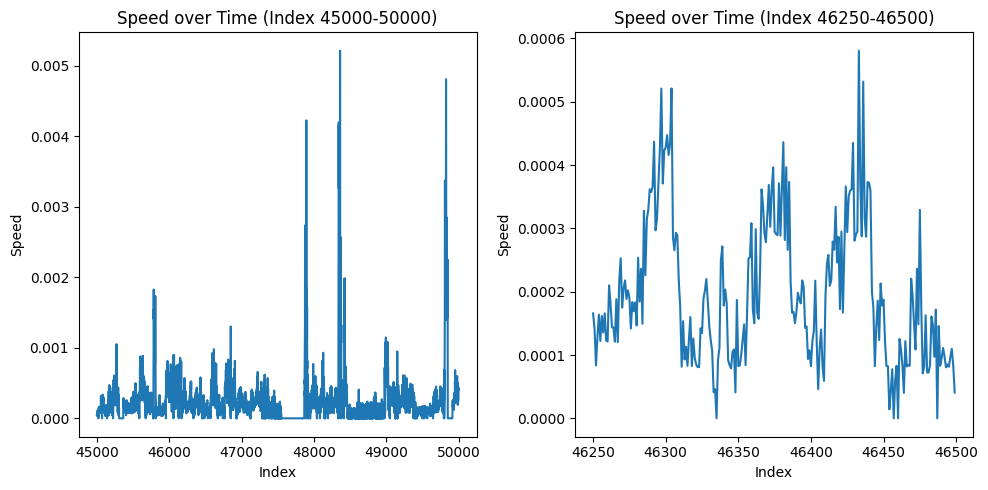

In [10]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot on the first subplot
human_df['speed'][45000:50000].plot(use_index=True, ax=axes[0])
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Speed')
axes[0].set_title('Speed over Time (Index 45000-50000)')

# Plot on the second subplot
human_df['speed'][46250:46500].plot(use_index=True, ax=axes[1])
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Speed')
axes[1].set_title('Speed over Time (Index 46250-46500)')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [11]:
bot_data: Dict[str, Any] = {
    'dx': [],
    'dy': [],
    'speedX': [],
    'speedY': [],
    'speed' : [],
    'accel': [],
    'distance': [],
    'timeDiff': [],
    'jerk': [],
    'angle': [],
}

bot_df = pd.DataFrame(bot_data)

for session in bot_sessions.numpy():
  # `session` is a file_path for csv input.

  line = {
      'speedX': 0,
      'speedY': 0,
      'speed': 0,
      'accel': 0,
  }

  with open(session.decode('utf-8')) as f:
    content = f.readlines()
    resX, resY = 1, 1
    if content[0].startswith('resolution'):
      resX, resY = map(float, content[0][11:].split(','))
      content = content[1:]

    content.insert(0, 'timstamp,action,x,y')

    for i in range(1, len(content)):
      ts, act, x, y = content[i].split(',')
      ts, x, y = float(ts), float(x)/resX, float(y)/resY

      if act.lower() != 'move':
        continue

      if ts - line.get('time', 0) == 0:
        continue

      new_bot_data = calc_features(ts, x, y, line)

      line = new_bot_data.copy()

      del new_bot_data['time']
      del new_bot_data['x']
      del new_bot_data['y']

      for key in new_bot_data:
        new_bot_data[key] = [new_bot_data[key]]

      bot_df = pd.concat([bot_df, pd.DataFrame(new_bot_data)], ignore_index=True)


bot_df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2853763.7,0.000000e+00,0.000000,0.000000e+00,0.000000
1,-1.953125e-03,0.006944,-6.424753e-05,0.000228,2.372986e-04,7.805873e-06,7.213876e-03,30.4,7.805873e-06,1.844964,-2.113406e-06,0.000008
2,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,-1.483116e-04,0.000000e+00,1.6,-1.531903e-04,0.000000,4.015471e-05,-0.000143
3,-3.255208e-03,0.005787,-2.034505e-04,0.000362,4.149839e-04,2.593649e-05,6.639742e-03,16.0,3.520597e-05,2.083186,-1.271566e-05,0.000023
4,-2.604167e-03,0.005787,-7.727498e-05,0.000172,1.883081e-04,-6.726286e-06,6.345982e-03,33.7,-7.495915e-06,1.993650,3.744081e-06,-0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
264866,4.238553e-07,0.000000,3.027538e-08,0.000000,3.027538e-08,2.162527e-09,4.238553e-07,14.0,2.162527e-09,0.000000,2.162527e-09,0.000000
264867,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,-2.162527e-09,0.000000e+00,14.0,-2.316993e-09,0.000000,-2.162527e-09,0.000000
264868,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,15.0,1.441685e-10,0.000000,0.000000e+00,0.000000
264869,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,50.0,0.000000e+00,0.000000,0.000000e+00,0.000000


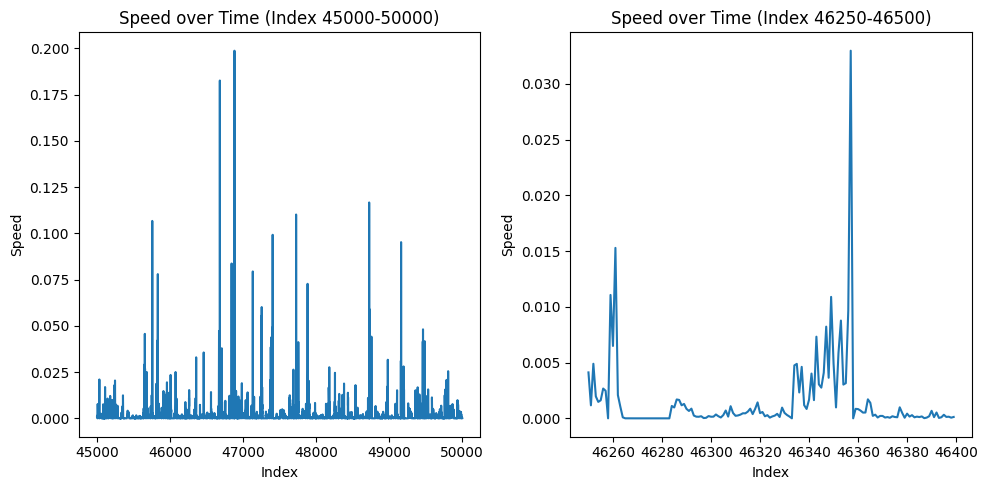

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot on the first subplot
bot_df['speed'][45000:50000].plot(use_index=True, ax=axes[0])
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Speed')
axes[0].set_title('Speed over Time (Index 45000-50000)')

# Plot on the second subplot
bot_df['speed'][46250:46400].plot(use_index=True, ax=axes[1])
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Speed')
axes[1].set_title('Speed over Time (Index 46250-46500)')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [13]:
# Add Labels
human_df['label'] = 0
bot_df['label'] = 1

In [14]:
human_df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY,label
0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,423862.3,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0
1,0.002604,0.000000,1.607510e-04,0.000000e+00,1.607510e-04,9.922903e-06,0.002604,16.2,9.922903e-06,0.000000,9.922903e-06,0.000000e+00,0
2,0.002604,0.000000,1.648207e-04,0.000000e+00,1.648207e-04,2.575725e-07,0.002604,15.8,-3.704593e-07,0.000000,2.575725e-07,0.000000e+00,0
3,0.002604,0.000926,1.617495e-04,5.751093e-05,1.716695e-04,4.253901e-07,0.002764,16.1,4.093918e-07,0.341615,-1.907573e-07,3.572107e-06,0
4,0.003125,0.002778,1.965409e-04,1.747030e-04,2.629628e-04,5.741723e-06,0.004181,15.9,5.714969e-06,0.726642,2.188138e-06,7.370571e-06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109909,-0.000003,0.000000,-6.055075e-08,0.000000e+00,6.055075e-08,-3.068060e-08,0.000003,49.0,-2.038583e-08,3.141593,1.018894e-08,2.980149e-08,0
109910,-0.000027,0.000042,-5.340576e-07,8.443034e-07,9.990324e-07,1.876963e-08,0.000050,50.0,1.938325e-08,2.134801,-9.470137e-09,1.688607e-08,0
109911,-0.000015,0.000102,-5.086263e-06,3.400667e-05,3.438493e-05,1.112863e-05,0.000103,3.0,1.112238e-05,1.719262,-1.517402e-06,1.105412e-05,0
109912,0.000008,0.000123,1.541292e-07,2.238683e-06,2.243983e-06,-5.843808e-07,0.000123,55.0,-7.867196e-07,1.502057,9.527986e-08,-5.775997e-07,0


In [15]:
bot_df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY,label
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2853763.7,0.000000e+00,0.000000,0.000000e+00,0.000000,1
1,-1.953125e-03,0.006944,-6.424753e-05,0.000228,2.372986e-04,7.805873e-06,7.213876e-03,30.4,7.805873e-06,1.844964,-2.113406e-06,0.000008,1
2,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,-1.483116e-04,0.000000e+00,1.6,-1.531903e-04,0.000000,4.015471e-05,-0.000143,1
3,-3.255208e-03,0.005787,-2.034505e-04,0.000362,4.149839e-04,2.593649e-05,6.639742e-03,16.0,3.520597e-05,2.083186,-1.271566e-05,0.000023,1
4,-2.604167e-03,0.005787,-7.727498e-05,0.000172,1.883081e-04,-6.726286e-06,6.345982e-03,33.7,-7.495915e-06,1.993650,3.744081e-06,-0.000006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264866,4.238553e-07,0.000000,3.027538e-08,0.000000,3.027538e-08,2.162527e-09,4.238553e-07,14.0,2.162527e-09,0.000000,2.162527e-09,0.000000,1
264867,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,-2.162527e-09,0.000000e+00,14.0,-2.316993e-09,0.000000,-2.162527e-09,0.000000,1
264868,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,15.0,1.441685e-10,0.000000,0.000000e+00,0.000000,1
264869,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,50.0,0.000000e+00,0.000000,0.000000e+00,0.000000,1


In [16]:
df = pd.concat([human_df, bot_df], ignore_index=True)
df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY,label
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,423862.3,0.000000e+00,0.000000,0.000000e+00,0.000000,0
1,2.604167e-03,0.000000,1.607510e-04,0.000000,1.607510e-04,9.922903e-06,2.604167e-03,16.2,9.922903e-06,0.000000,9.922903e-06,0.000000,0
2,2.604167e-03,0.000000,1.648207e-04,0.000000,1.648207e-04,2.575725e-07,2.604167e-03,15.8,-3.704593e-07,0.000000,2.575725e-07,0.000000,0
3,2.604167e-03,0.000926,1.617495e-04,0.000058,1.716695e-04,4.253901e-07,2.763878e-03,16.1,4.093918e-07,0.341615,-1.907573e-07,0.000004,0
4,3.125000e-03,0.002778,1.965409e-04,0.000175,2.629628e-04,5.741723e-06,4.181109e-03,15.9,5.714969e-06,0.726642,2.188138e-06,0.000007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374780,4.238553e-07,0.000000,3.027538e-08,0.000000,3.027538e-08,2.162527e-09,4.238553e-07,14.0,2.162527e-09,0.000000,2.162527e-09,0.000000,1
374781,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,-2.162527e-09,0.000000e+00,14.0,-2.316993e-09,0.000000,-2.162527e-09,0.000000,1
374782,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,15.0,1.441685e-10,0.000000,0.000000e+00,0.000000,1
374783,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,50.0,0.000000e+00,0.000000,0.000000e+00,0.000000,1


In [17]:
df.to_csv('processed_data.csv', index=False)

### Load Pre-Processed Data from CSV

In [18]:
df = pd.read_csv('processed_data.csv')

In [19]:
df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY,label
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,423862.3,0.000000e+00,0.000000,0.000000e+00,0.000000,0
1,2.604167e-03,0.000000,1.607510e-04,0.000000,1.607510e-04,9.922903e-06,2.604167e-03,16.2,9.922903e-06,0.000000,9.922903e-06,0.000000,0
2,2.604167e-03,0.000000,1.648207e-04,0.000000,1.648207e-04,2.575725e-07,2.604167e-03,15.8,-3.704593e-07,0.000000,2.575725e-07,0.000000,0
3,2.604167e-03,0.000926,1.617495e-04,0.000058,1.716695e-04,4.253901e-07,2.763878e-03,16.1,4.093918e-07,0.341615,-1.907573e-07,0.000004,0
4,3.125000e-03,0.002778,1.965409e-04,0.000175,2.629628e-04,5.741723e-06,4.181109e-03,15.9,5.714969e-06,0.726642,2.188138e-06,0.000007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374780,4.238553e-07,0.000000,3.027538e-08,0.000000,3.027538e-08,2.162527e-09,4.238553e-07,14.0,2.162527e-09,0.000000,2.162527e-09,0.000000,1
374781,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,-2.162527e-09,0.000000e+00,14.0,-2.316993e-09,0.000000,-2.162527e-09,0.000000,1
374782,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,15.0,1.441685e-10,0.000000,0.000000e+00,0.000000,1
374783,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,50.0,0.000000e+00,0.000000,0.000000e+00,0.000000,1


### Split into Training and Testing Datasets

In [42]:
X = df.drop('label', axis = 1)
y = df['label']

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [44]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(299828, 12) (74957, 12) (299828,) (74957,)


In [45]:
X_train

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,423862.3,0.000000e+00,0.000000,0.000000e+00,0.000000
1,0.002604,0.000000,0.000161,0.000000,0.000161,9.922903e-06,0.002604,16.2,9.922903e-06,0.000000,9.922903e-06,0.000000
2,0.002604,0.000000,0.000165,0.000000,0.000165,2.575725e-07,0.002604,15.8,-3.704593e-07,0.000000,2.575725e-07,0.000000
3,0.002604,0.000926,0.000162,0.000058,0.000172,4.253901e-07,0.002764,16.1,4.093918e-07,0.341615,-1.907573e-07,0.000004
4,0.003125,0.002778,0.000197,0.000175,0.000263,5.741723e-06,0.004181,15.9,5.714969e-06,0.726642,2.188138e-06,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...
299823,0.001042,0.000926,0.000067,0.000060,0.000090,2.025531e-06,0.001394,15.5,1.946364e-06,0.726642,5.602388e-07,0.000004
299824,0.001042,0.000000,0.000064,0.000000,0.000064,-1.609760e-06,0.001042,16.4,-1.733268e-06,0.000000,-2.248805e-07,-0.000004
299825,0.001042,0.000000,0.000066,0.000000,0.000066,1.526589e-07,0.001042,15.8,2.545424e-07,0.000000,1.526589e-07,0.000000
299826,0.001042,-0.000926,0.000064,-0.000057,0.000086,1.240913e-06,0.001394,16.2,1.231489e-06,-0.726642,-1.004851e-07,-0.000004


## Model Training

### Architecture

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM, LeakyReLU, BatchNormalization, Dropout

model_rnn = tf.keras.Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    LSTM(
        64,
        activation='tanh',
        recurrent_activation='hard_sigmoid',
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_initializer='variance_scaling',
        recurrent_initializer='orthogonal',
      ),
    LeakyReLU(alpha=0.1),
    BatchNormalization(momentum=0.99, epsilon=0.001),
    Dropout(0.3),
    LSTM(32, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False,
          recurrent_dropout=0.2, kernel_initializer='variance_scaling', recurrent_initializer='orthogonal'),
    LeakyReLU(alpha=0.1),
    #tf.keras.layers.GlobalAveragePooling1D(),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [47]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model_rnn.compile(loss= BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(),
              metrics = ['accuracy', 'AUC'])

In [48]:
model_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
model_rnn.fit(
    X_train,
    y_train,
    epochs = 1,
    batch_size = 32,
    verbose = 1,
    validation_data=(X_test, y_test)
)

9370/9370 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - AUC: 0.5366 - accuracy: 0.6295 - loss: 0.6563 - val_AUC: 0.0000e+00 - val_accuracy: 0.9974 - val_loss: 0.4644


### Save Model

In [31]:
model_rnn.save('/content/SIH.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/SIH /content/drive/'My Drive'/SIH2024

### Parse an example response

In [50]:
import json

with open('readings.json', 'r') as f:
    readings = json.load(f)

print(readings)

{'key_count': 32, 'key_sequence': ['Control', 'Shift', 'I', 'Alt', 'Control', 'Shift', 'Alt', 'Alt', 'Alt', 'Alt', 'Alt', 'Alt', 'Alt', 'Alt', 'Alt', 'Control', 'Shift', 'I', 's', 'a', 'd', 'f', 'a', 'd', 'f', 'a', 's', 'd', 'f', 'a', 's', 'f'], 'time_delay': [43, 236, 878911, 5627, 48, 8979, 1223, 7363, 4159, 67443, 155176, 2640, 3744, 4292, 79065, 122, 149, 9343, 6, 45, 65, 91, 80, 14, 1071, 24, 28, 72, 97, 38, 36], 'mouse_movements': [{'x': 839, 'y': 124, 'timeDelay': 1889, 'timestamp': 1725564051220}, {'x': 840, 'y': 123, 'timeDelay': 45, 'timestamp': 1725564051265}, {'x': 840, 'y': 122, 'timeDelay': 10, 'timestamp': 1725564051275}, {'x': 912, 'y': 93, 'timeDelay': 30, 'timestamp': 1725564051305}, {'x': 995, 'y': 73, 'timeDelay': 34, 'timestamp': 1725564051339}, {'x': 1137, 'y': 54, 'timeDelay': 33, 'timestamp': 1725564051372}, {'x': 1212, 'y': 50, 'timeDelay': 33, 'timestamp': 1725564051405}, {'x': 1234, 'y': 50, 'timeDelay': 34, 'timestamp': 1725564051439}, {'x': 1228, 'y': 50, '

In [51]:
session_data: Dict[str, Any] = {
    'dx': [],
    'dy': [],
    'speedX': [],
    'speedY': [],
    'speed' : [],
    'accel': [],
    'distance': [],
    'timeDiff': [],
    'jerk': [],
    'angle': [],
}

session_df = pd.DataFrame(session_data)

line = {
    'speedX': 0,
    'speedY': 0,
    'speed': 0,
    'accel': 0,
}

resX, resY = 1920, 1080
mouse_movements = readings['mouse_movements']
for movement in mouse_movements:
    ts, x, y = movement['timestamp'], movement['x']/resX, movement['y']/resY

    if ts - line.get('time', 0) == 0:
        continue

    new_session_data = calc_features(ts, x, y, line)

    line = new_session_data.copy()

    del new_session_data['time']
    del new_session_data['x']
    del new_session_data['y']

    for key in new_session_data:
        new_session_data[key] = [new_session_data[key]]

    session_df = pd.concat([session_df, pd.DataFrame(new_session_data)], ignore_index=True)

session_df

,dx,dy,speedX,speedY,speed,accel,distance,timeDiff,jerk,angle,accelX,accelY
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.725564e+12,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,0.000521,-0.000926,0.000012,-0.000021,0.000024,5.246216e-07,0.001062,4.500000e+01,5.246216e-07,-1.058407,2.572016e-07,-4.572474e-07
2,0.000000,-0.000926,0.000000,-0.000093,0.000093,6.898462e-06,0.000926,1.000000e+01,6.846000e-06,-1.570796,-1.157407e-06,-7.201646e-06
3,0.037500,-0.026852,0.001250,-0.000895,0.001537,4.816065e-05,0.046122,3.000000e+01,4.793070e-05,-0.621416,4.166667e-05,-2.674897e-05
4,0.043229,-0.018519,0.001271,-0.000545,0.001383,-4.535753e-06,0.047029,3.400000e+01,-5.952242e-06,-0.404730,6.307670e-07,1.030587e-05
...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.020313,-0.024074,0.002539,-0.003009,0.003937,-1.135765e-04,0.031499,8.000000e+00,-1.751916e-04,-0.869942,-7.324219e-05,8.680556e-05
341,0.011979,-0.012037,0.001711,-0.001720,0.002426,-2.159013e-04,0.016982,7.000000e+00,-1.996761e-04,-0.787808,-1.182504e-04,1.842404e-04
342,0.015625,-0.014815,0.003125,-0.002963,0.004306,3.760709e-04,0.021532,5.000000e+00,4.192511e-04,-0.758788,2.827381e-04,-2.486772e-04
343,0.010937,-0.013889,0.001562,-0.001984,0.002526,-2.544088e-04,0.017679,7.000000e+00,-3.081332e-04,-0.903724,-2.232143e-04,1.398337e-04


In [53]:
results = tf.squeeze(model_rnn.predict(session_df))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [55]:
results

<tf.Tensor: shape=(345,), dtype=float32, numpy=
array([0.74962604, 0.6460254 , 0.5634027 , 0.6648247 , 0.7121993 ,
       0.74748665, 0.74713415, 0.7447257 , 0.6060718 , 0.7858819 ,
       0.76225024, 0.7378699 , 0.74144995, 0.6590329 , 0.7432234 ,
       0.74440145, 0.7064811 , 0.6440005 , 0.6141216 , 0.6004403 ,
       0.5954517 , 0.593266  , 0.6571418 , 0.6524017 , 0.6644708 ,
       0.672436  , 0.6601196 , 0.788168  , 0.59389716, 0.6142256 ,
       0.61087525, 0.60751194, 0.60492617, 0.63205206, 0.6498219 ,
       0.63531435, 0.62006885, 0.6136303 , 0.64585286, 0.7444727 ,
       0.74382627, 0.63991296, 0.64342713, 0.6377518 , 0.64711624,
       0.63947314, 0.63520074, 0.6570324 , 0.65810937, 0.65703243,
       0.65703243, 0.74404466, 0.6581095 , 0.639507  , 0.64646786,
       0.6408752 , 0.6570323 , 0.6535521 , 0.64465743, 0.67017984,
       0.6732858 , 0.59688085, 0.6924994 , 0.60877836, 0.615735  ,
       0.60350835, 0.69045055, 0.6036956 , 0.5438553 , 0.60522926,
       0.61067

In [60]:
import tensorflow as tf

def count_values_above_threshold(tensor, threshold):
  count = tf.reduce_sum(tf.cast(tensor > threshold, tf.int32))
  return count

threshold = 0.65
count = count_values_above_threshold(results, threshold)

print(count / len(results))

tf.Tensor(0.2318840579710145, shape=(), dtype=float64)
